# PREVIEW: Model Inference & Batch Prediction

This notebook demonstrates how to use the trained fraud detection model for batch inference, including data preprocessing, prediction generation, and results analysis. It also provides utilities for model validation and performance monitoring.

## Notebook Objectives:
- **Batch Inference**: Process large datasets with trained model
- **Data Preprocessing**: Apply same transformations as training
- **Prediction Analysis**: Analyze fraud patterns and distributions
- **Model Validation**: Verify model performance on new data
- **Results Export**: Generate reports and save predictions

## Learning Objectives

- Load the trained model through the shared inference pipeline
- Run both single and batch predictions with consistent feature engineering
- Inspect prediction outputs and export inference-ready artefacts


## SETUP: Setup and Configuration

In [17]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.config import ConfigManager
from src.inference import InferencePipeline, create_sample_transaction

plt.style.use('seaborn-v0_8')


In [18]:
config_manager = ConfigManager()
training_config = config_manager.get_training_config()
serving_config = config_manager.get_serving_config()

print('INFO: Loaded training and serving configuration files')
print(f"   - Local model artefact: {serving_config['model']['local_model_path']}")
print(f"   - Fraud threshold: {serving_config['prediction']['fraud_threshold']}")


INFO: Loaded training and serving configuration files
   - Local model artefact: models/xgboost_final_model.joblib
   - Fraud threshold: 0.5


In [19]:
training_summary_path = Path('../data/training_summary.json')
if training_summary_path.exists():
    training_summary = json.loads(training_summary_path.read_text())
    print('INFO: Training summary loaded')
    print(f"   - Best model: {training_summary.get('best_model')}")
    print(f"   - Training timestamp: {training_summary.get('timestamp')}")
else:
    training_summary = None
    print('WARN Training summary not found; continuing without it.')


INFO: Training summary loaded
   - Best model: logistic_regression
   - Training timestamp: 2025-10-01T16:04:56.450353


In [20]:
model_path = serving_config['model']['local_model_path']
inference_pipeline = InferencePipeline(model_path=model_path)
print('INFO: Inference pipeline initialised')
print('Model metadata:', inference_pipeline.get_model_info())


INFO: Inference pipeline initialised
Model metadata: {'model_type': 'XGBClassifier', 'metadata': {'source': 'file', 'path': 'models/xgboost_final_model.joblib', 'loaded_at': '2025-10-01T14:07:56.740650'}, 'feature_count': 52, 'n_estimators': 300, 'max_depth': 3}


## Processing: Advanced Feature Engineering for Inference

Replicate the exact feature engineering pipeline used during training to ensure consistency.

In [22]:
# Use the feature engineer from the inference pipeline to guarantee parity
feature_engineer = inference_pipeline.feature_engineer
print('Feature engineering pipeline ready with', len(inference_pipeline.feature_names), 'features')


Feature engineering pipeline ready with 52 features


## Data: Batch Inference Pipeline

In [24]:
model_info = inference_pipeline.get_model_info()
print('Model source:', model_info.get('metadata', {}))
print('Feature count:', model_info.get('feature_count'))


Model source: {'source': 'file', 'path': 'models/xgboost_final_model.joblib', 'loaded_at': '2025-10-01T14:07:56.740650'}
Feature count: 52


## TEST: Demo: Inference on Sample Data

In [25]:
# Create sample transaction data for demonstration
def create_sample_transactions(n_samples=1000):
    """Create sample transaction data for inference demo"""
    rng = np.random.default_rng(seed=42)

    merchant_categories = ['grocery', 'gas_station', 'restaurant', 'retail', 'online', 'entertainment']
    transaction_types = ['purchase', 'withdrawal', 'transfer', 'payment']
    locations = ['seattle_wa', 'portland_or', 'san_francisco_ca', 'los_angeles_ca', 'denver_co']
    device_types = ['mobile', 'desktop', 'atm', 'pos']

    records = []
    for i in range(n_samples):
        hour_probs = np.array([0.02, 0.01, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                               0.07, 0.08, 0.08, 0.07, 0.07, 0.08, 0.09, 0.08,
                               0.07, 0.06, 0.05, 0.04, 0.04, 0.03, 0.02, 0.02], dtype=float)
        hour_probs /= hour_probs.sum()
        hour = rng.choice(np.arange(24), p=hour_probs)

        is_suspicious = rng.random() < 0.05
        if is_suspicious:
            amount = rng.lognormal(7, 1.2)
            hour = rng.choice([0, 1, 2, 3, 22, 23])
            merchant_cat = rng.choice(['online', 'entertainment'])
            device_type = rng.choice(['atm', 'desktop'])
        else:
            amount = rng.lognormal(4, 0.9)
            merchant_cat = rng.choice(merchant_categories)
            device_type = rng.choice(device_types)

        record = {
            'transaction_id': f'txn_{i+1:06d}',
            'user_id': f'user_{rng.integers(1, 5000):05d}',
            'device_id': f'device_{rng.integers(1, 2000):05d}',
            'amount': float(np.round(amount, 2)),
            'merchant_category': merchant_cat,
            'transaction_type': rng.choice(transaction_types),
            'location': rng.choice(locations),
            'device_type': device_type,
            'hour_of_day': int(hour),
            'day_of_week': int(rng.integers(0, 7)),
            'user_transaction_frequency': float(rng.uniform(1, 20)),
            'user_avg_amount': float(rng.uniform(50, 300)),
            'user_transaction_count': int(rng.integers(1, 100)),
            'timestamp': datetime.now() - timedelta(hours=int(rng.integers(0, 720)))
        }
        records.append(record)

    return pd.DataFrame(records)

print('Processing: Generating sample transaction data...')
sample_df = create_sample_transactions(1000)

print(f'Data: Sample data created: {sample_df.shape}')
print('Sample transactions:')
display(sample_df.head())


Processing: Generating sample transaction data...
Data: Sample data created: (1000, 14)
Sample transactions:


,transaction_id,user_id,device_id,amount,merchant_category,transaction_type,location,device_type,hour_of_day,day_of_week,user_transaction_frequency,user_avg_amount,user_transaction_count,timestamp
0,txn_000001,user_01008,device_00189,107.28,grocery,transfer,denver_co,atm,16,5,15.935222,82.028408,76,2025-09-06 12:09:57.570102
1,txn_000002,user_04113,device_01091,57.94,restaurant,withdrawal,san_francisco_ca,desktop,10,1,11.537111,65.954314,85,2025-09-06 21:09:57.570267
2,txn_000003,user_02228,device_01786,29.58,grocery,transfer,los_angeles_ca,pos,14,5,9.867699,60.950941,20,2025-09-15 07:09:57.570555
3,txn_000004,user_01629,device_01811,37.87,grocery,withdrawal,seattle_wa,desktop,15,3,4.599956,82.480376,68,2025-09-17 10:09:57.570685
4,txn_000005,user_03149,device_01400,106.58,grocery,purchase,portland_or,pos,8,5,16.290523,146.869595,83,2025-09-04 18:09:57.570844


In [26]:
print('Inference: running batch predictions with the production pipeline...')
results_df = inference_pipeline.predict_batch(sample_df, include_probabilities=True)

fraud_threshold = serving_config['prediction']['fraud_threshold']
results_df['risk_level'] = np.where(
    results_df['fraud_probability'] >= fraud_threshold + 0.2, 'high',
    np.where(results_df['fraud_probability'] >= fraud_threshold, 'medium', 'low')
)

print(f"OK Predictions generated for {len(results_df)} transactions")
print(results_df[['transaction_id', 'fraud_probability', 'risk_level']].head())


Inference: running batch predictions with the production pipeline...
OK Predictions generated for 1000 transactions
  transaction_id  fraud_probability risk_level
0     txn_000001           0.278100        low
1     txn_000002           0.435047        low
2     txn_000003           0.455231        low
3     txn_000004           0.418192        low
4     txn_000005           0.295642        low


In [28]:
print("Analysis: Feature Engineering vs Model Expectations")
print("=" * 50)

model = inference_pipeline.model

print("1) Model feature requirements:")
if hasattr(model, 'feature_names_in_'):
    model_features = list(model.feature_names_in_)
    print(f"   - Expected features: {len(model_features)}")
    print(f"   - First 5: {model_features[:5]}")
else:
    print(f"   - Expected {model.n_features_in_} features (names not stored)")

print("\n2) Selected training features:")
try:
    with open('../data/selected_features.json', 'r') as f:
        training_metadata = json.load(f)
    training_features = training_metadata['selected_features']
    print(f"   - Training selected: {len(training_features)}")
    print(f"   - First 5: {training_features[:5]}")
except Exception as exc:
    print(f"   - Error loading training features: {exc}")

print("\n3) Inference feature generation check:")
mini_sample = pd.DataFrame([create_sample_transaction()])
processed = inference_pipeline.preprocess_data(mini_sample)
print(f"   - Generated {processed.shape[1]} features")
if hasattr(model, 'feature_names_in_'):
    missing = set(model.feature_names_in_) - set(processed.columns)
    extra = set(processed.columns) - set(model.feature_names_in_)
    print(f"   - Missing features relative to model: {len(missing)}")
    print(f"   - Extra features relative to model: {len(extra)}")


Analysis: Feature Engineering vs Model Expectations
1) Model feature requirements:
   - Expected features: 52
   - First 5: [np.str_('amount'), np.str_('merchant_category'), np.str_('transaction_type'), np.str_('device_type'), np.str_('location')]

2) Selected training features:
   - Training selected: 11
   - First 5: ['user_std_amount', 'user_unique_locations', 'user_avg_amount', 'amount_zscore', 'user_transaction_count']

3) Inference feature generation check:
   - Generated 52 features
   - Missing features relative to model: 0
   - Extra features relative to model: 0


In [29]:
single_txn = create_sample_transaction()
print('Single transaction input:')
print(single_txn)

single_prediction = inference_pipeline.predict_single(single_txn)
print('Prediction result:')
for key, value in single_prediction.items():
    print(f"   - {key}: {value}")


Single transaction input:
{'transaction_id': 'txn_337379', 'user_id': 'user_01473', 'device_id': 'device_01678', 'amount': 252.91, 'merchant_category': np.str_('entertainment'), 'transaction_type': np.str_('withdrawal'), 'location': np.str_('los_angeles_ca'), 'device_type': np.str_('atm'), 'hour_of_day': 14, 'day_of_week': 1, 'user_transaction_frequency': 19.89341155458816, 'user_avg_amount': 234.19052771248732, 'user_transaction_count': 6, 'timestamp': datetime.datetime(2025, 9, 29, 21, 11, 10, 259223)}
Prediction result:
   - transaction_id: txn_337379
   - user_id: user_01473
   - device_id: device_01678
   - amount: 252.91
   - merchant_category: entertainment
   - transaction_type: withdrawal
   - location: los_angeles_ca
   - device_type: atm
   - hour_of_day: 14
   - day_of_week: 1
   - user_transaction_frequency: 19.89341155458816
   - user_avg_amount: 234.19052771248732
   - user_transaction_count: 6
   - timestamp: 2025-09-29 21:11:10.259223
   - fraud_prediction: 1
   - pred

## Data: Visualization and Analysis

In [31]:
print("OBJECTIVE: Model ready for inference")
print("=" * 40)
print('Model metadata:')
for key, value in inference_pipeline.get_model_info().items():
    print(f"   - {key}: {value}")


OBJECTIVE: Model ready for inference
Model metadata:
   - model_type: XGBClassifier
   - metadata: {'source': 'file', 'path': 'models/xgboost_final_model.joblib', 'loaded_at': '2025-10-01T14:07:56.740650'}
   - feature_count: 52
   - n_estimators: 300
   - max_depth: 3


In [32]:
print('Analysis: summarising inference results...')

analysis_results = {
    'total_transactions': int(len(results_df)),
    'fraud_cases': int(results_df['fraud_prediction'].sum()),
    'fraud_rate': float(results_df['fraud_prediction'].mean()),
    'avg_fraud_probability': float(results_df['fraud_probability'].mean()),
    'risk_distribution': results_df['risk_level'].value_counts().to_dict(),
}

print(f"Fraud cases detected: {analysis_results['fraud_cases']} ({analysis_results['fraud_rate']:.2%})")
print(f"Average fraud probability: {analysis_results['avg_fraud_probability']:.3f}")
print('Risk distribution:')
for level, count in analysis_results['risk_distribution'].items():
    print(f"   - {level}: {count}")


Analysis: summarising inference results...
Fraud cases detected: 320 (32.00%)
Average fraud probability: 0.448
Risk distribution:
   - low: 680
   - medium: 299
   - high: 21


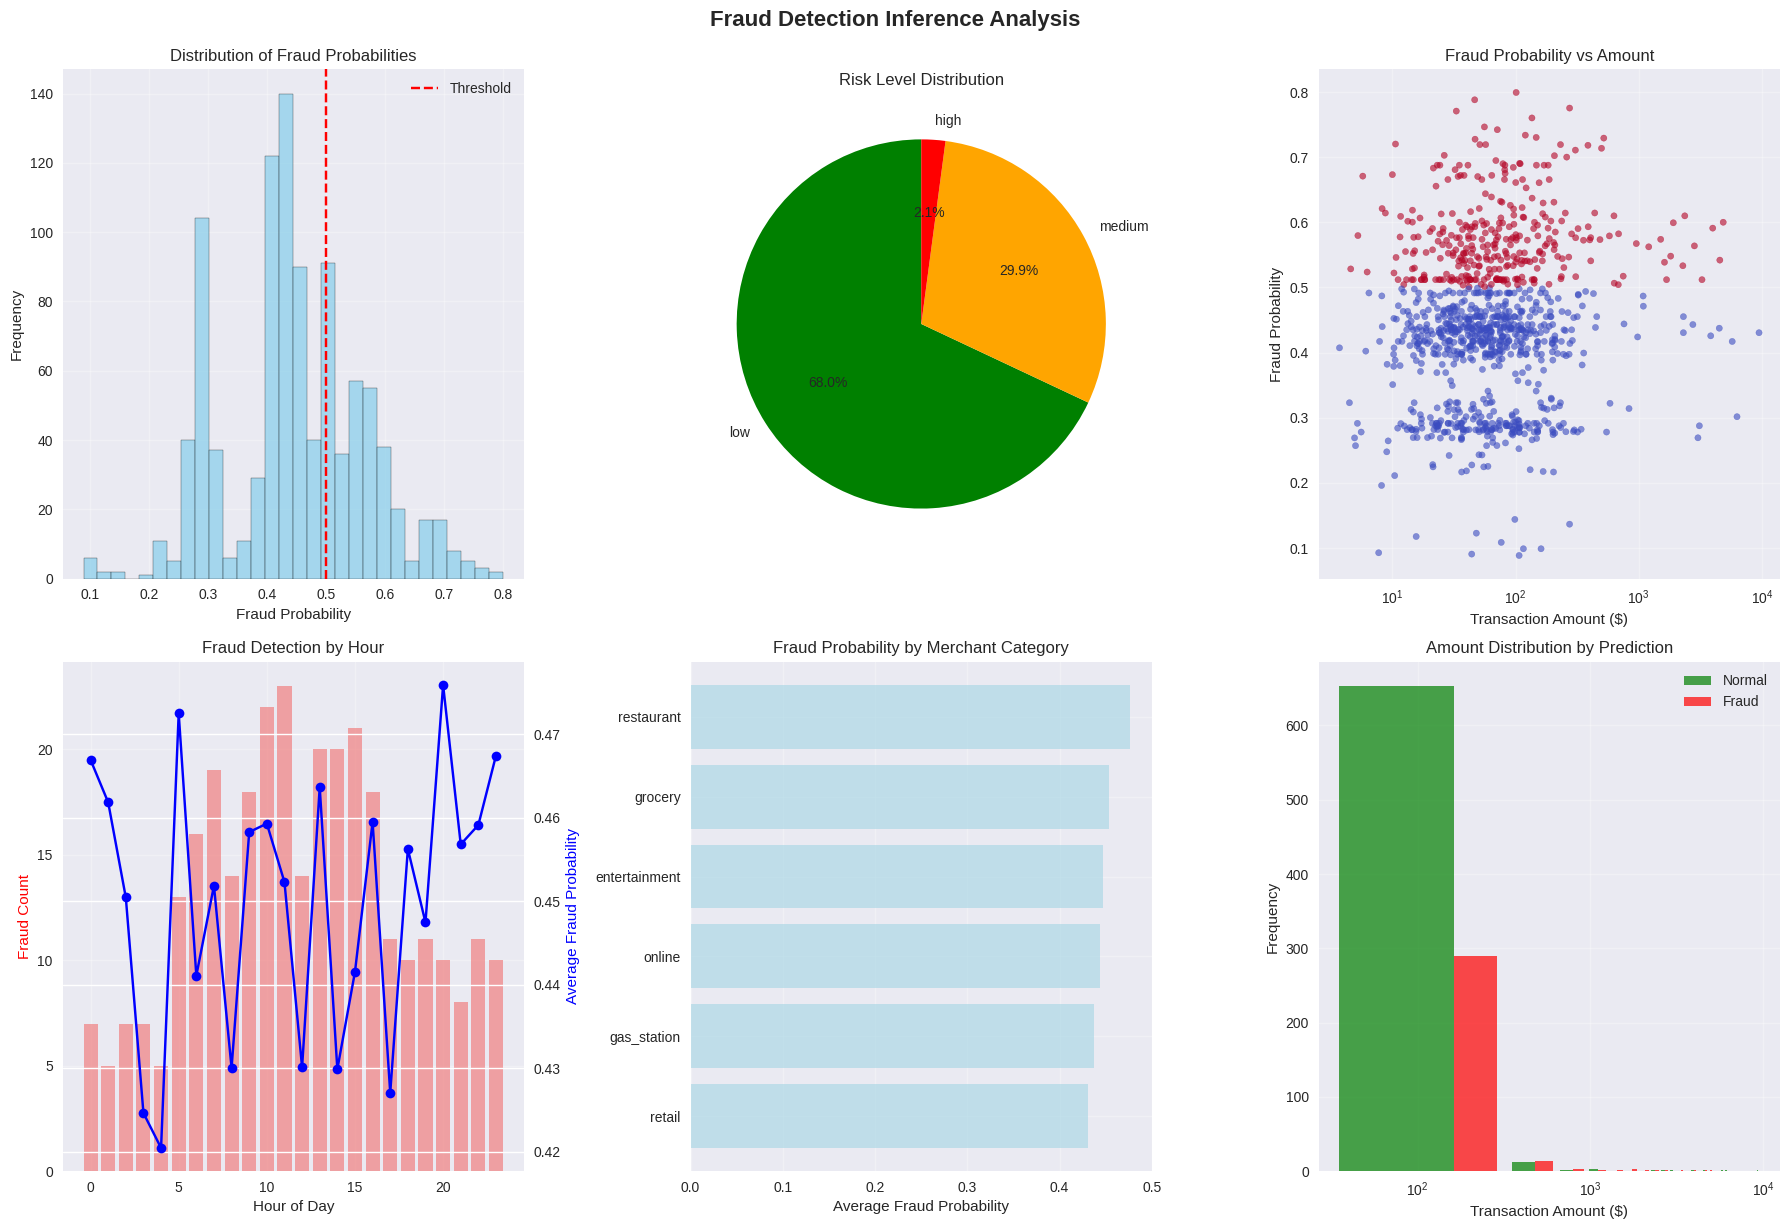

In [33]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# 1. Fraud probability distribution
axes[0].hist(results_df['fraud_probability'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Threshold')
axes[0].set_xlabel('Fraud Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Fraud Probabilities')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Risk level distribution
risk_counts = results_df['risk_level'].value_counts()
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}
risk_colors = [colors[level] for level in risk_counts.index]
axes[1].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
            colors=risk_colors, startangle=90)
axes[1].set_title('Risk Level Distribution')

# 3. Fraud probability by amount
axes[2].scatter(results_df['amount'], results_df['fraud_probability'], 
                alpha=0.6, c=results_df['fraud_prediction'], 
                cmap='coolwarm', s=20)
axes[2].set_xlabel('Transaction Amount ($)')
axes[2].set_ylabel('Fraud Probability')
axes[2].set_title('Fraud Probability vs Amount')
axes[2].set_xscale('log')
axes[2].grid(True, alpha=0.3)

# 4. Fraud by hour of day
hourly_fraud = results_df.groupby('hour_of_day').agg({
    'fraud_probability': 'mean',
    'fraud_prediction': 'sum'
}).reset_index()

axes[3].bar(hourly_fraud['hour_of_day'], hourly_fraud['fraud_prediction'], 
            alpha=0.7, color='lightcoral', label='Fraud Count')
ax3_twin = axes[3].twinx()
ax3_twin.plot(hourly_fraud['hour_of_day'], hourly_fraud['fraud_probability'], 
              'bo-', label='Avg Probability')
axes[3].set_xlabel('Hour of Day')
axes[3].set_ylabel('Fraud Count', color='red')
ax3_twin.set_ylabel('Average Fraud Probability', color='blue')
axes[3].set_title('Fraud Detection by Hour')
axes[3].grid(True, alpha=0.3)

# 5. Fraud by merchant category
merchant_fraud = results_df.groupby('merchant_category').agg({
    'fraud_probability': 'mean',
    'fraud_prediction': 'sum'
}).sort_values('fraud_probability', ascending=True)

axes[4].barh(range(len(merchant_fraud)), merchant_fraud['fraud_probability'], 
             alpha=0.7, color='lightblue')
axes[4].set_yticks(range(len(merchant_fraud)))
axes[4].set_yticklabels(merchant_fraud.index)
axes[4].set_xlabel('Average Fraud Probability')
axes[4].set_title('Fraud Probability by Merchant Category')
axes[4].grid(True, alpha=0.3)

# 6. Amount distribution by prediction
fraud_amounts = results_df[results_df['fraud_prediction'] == 1]['amount']
normal_amounts = results_df[results_df['fraud_prediction'] == 0]['amount']

axes[5].hist([normal_amounts, fraud_amounts], bins=30, alpha=0.7, 
             label=['Normal', 'Fraud'], color=['green', 'red'])
axes[5].set_xlabel('Transaction Amount ($)')
axes[5].set_ylabel('Frequency')
axes[5].set_title('Amount Distribution by Prediction')
axes[5].set_xscale('log')
axes[5].legend()
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Fraud Detection Inference Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()

## Minimal Serving Demo (Optional)

You can launch a small FastAPI server that reuses the same inference pipeline:

```bash
uvicorn scripts.minimal_serve:app --reload --port 8000
```

Health check:
```bash
curl -s localhost:8000/health | jq
```

Single prediction (edit values as desired):
```bash
curl -s -X POST localhost:8000/predict   -H 'Content-Type: application/json'   -d '{
        "amount": 150.0,
        "merchant_category": "grocery",
        "transaction_type": "purchase",
        "location": "seattle_wa",
        "device_type": "mobile",
        "hour_of_day": 14,
        "day_of_week": 2,
        "user_transaction_frequency": 5.0,
        "user_avg_amount": 90.0,
        "user_transaction_count": 25
      }' | jq
```

This endpoint uses `scripts/minimal_serve.py` and the model artefact saved in `models/`.


## SAVE: Export Results and Reports

In [34]:
# Export inference results
def export_inference_results(results_df, analysis_results, export_dir='../data/inference_results'):
    """Export inference results and reports"""
    
    # Create export directory
    os.makedirs(export_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. Export detailed predictions
    predictions_file = f"{export_dir}/predictions_{timestamp}.csv"
    export_df = results_df[[
        'transaction_id', 'amount', 'merchant_category', 'transaction_type',
        'location', 'device_type', 'hour_of_day', 'day_of_week',
        'fraud_probability', 'fraud_prediction', 'risk_level', 'prediction_timestamp'
    ]]
    export_df.to_csv(predictions_file, index=False)
    print(f"FILE Predictions exported: {predictions_file}")
    
    # 2. Export fraud cases only
    fraud_cases_file = f"{export_dir}/fraud_cases_{timestamp}.csv"
    fraud_df = results_df[results_df['fraud_prediction'] == 1]
    if not fraud_df.empty:
        fraud_df.to_csv(fraud_cases_file, index=False)
        print(f"ALERT: Fraud cases exported: {fraud_cases_file}")
    
    # 3. Export high-risk transactions
    high_risk_file = f"{export_dir}/high_risk_{timestamp}.csv"
    high_risk_df = results_df[results_df['risk_level'] == 'high']
    if not high_risk_df.empty:
        high_risk_df.to_csv(high_risk_file, index=False)
        print(f"WARN High-risk transactions exported: {high_risk_file}")
    
    # 4. Export summary report
    summary_report = {
        'inference_timestamp': timestamp,
        'model_info': {
            'model_type': training_summary['best_model'] if training_summary else 'Unknown',
            'training_date': training_summary['timestamp'] if training_summary else 'Unknown'
        },
        'data_summary': {
            'total_transactions': len(results_df),
            'date_range': {
                'start': results_df['timestamp'].min().isoformat() if 'timestamp' in results_df.columns else None,
                'end': results_df['timestamp'].max().isoformat() if 'timestamp' in results_df.columns else None
            }
        },
        'prediction_results': analysis_results,
        'file_locations': {
            'predictions': predictions_file,
            'fraud_cases': fraud_cases_file if not fraud_df.empty else None,
            'high_risk': high_risk_file if not high_risk_df.empty else None
        }
    }
    
    summary_file = f"{export_dir}/inference_summary_{timestamp}.json"
    with open(summary_file, 'w') as f:
        json.dump(summary_report, f, indent=2, default=str)
    print(f"Data: Summary report exported: {summary_file}")
    
    return summary_report

# Export results
print("SAVE: Exporting inference results...")
export_summary = export_inference_results(results_df, analysis_results)

# Display export summary
print(f"\nInfo: Export Summary:")
print(f"   - Total files exported: {len([f for f in export_summary['file_locations'].values() if f])}")
print(f"   - Fraud cases: {len(results_df[results_df['fraud_prediction'] == 1])}")
print(f"   - High-risk transactions: {len(results_df[results_df['risk_level'] == 'high'])}")

SAVE: Exporting inference results...
FILE Predictions exported: ../data/inference_results/predictions_20251001_161222.csv
ALERT: Fraud cases exported: ../data/inference_results/fraud_cases_20251001_161222.csv
WARN High-risk transactions exported: ../data/inference_results/high_risk_20251001_161222.csv
Data: Summary report exported: ../data/inference_results/inference_summary_20251001_161222.json

Info: Export Summary:
   - Total files exported: 3
   - Fraud cases: 320
   - High-risk transactions: 21


## Processing: Model Performance Monitoring

In [35]:
# Monitor model performance over time
def monitor_model_performance(results_df, reference_metrics=None):
    """Monitor model performance and detect degradation"""
    
    print("Data: Model Performance Monitoring:")
    print("=" * 40)
    
    # Current batch metrics
    current_metrics = {
        'fraud_rate': results_df['fraud_prediction'].mean(),
        'avg_fraud_probability': results_df['fraud_probability'].mean(),
        'high_risk_rate': (results_df['risk_level'] == 'high').mean(),
        'prediction_count': len(results_df)
    }
    
    print(f"Current Batch Metrics:")
    for metric, value in current_metrics.items():
        print(f"  - {metric}: {value:.4f}")
    
    # Compare with reference metrics if available
    if reference_metrics:
        print(f"\nComparison with Reference:")
        for metric in current_metrics:
            if metric in reference_metrics:
                current = current_metrics[metric]
                reference = reference_metrics[metric]
                change = (current - reference) / reference * 100
                status = "STATS:" if change > 10 else "TREND" if change < -10 else "->"
                print(f"  {status} {metric}: {current:.4f} vs {reference:.4f} ({change:+.1f}%)")
    
    # Performance alerts
    alerts = []
    
    if current_metrics['fraud_rate'] > 0.1:  # >10% fraud rate
        alerts.append("ALERT: High fraud rate detected")
    
    if current_metrics['avg_fraud_probability'] > 0.3:  # High average probability
        alerts.append("WARN Elevated fraud probability scores")
    
    if current_metrics['high_risk_rate'] > 0.2:  # >20% high risk
        alerts.append("DOWN High proportion of risky transactions")
    
    if alerts:
        print(f"\nALERT: Performance Alerts:")
        for alert in alerts:
            print(f"  {alert}")
    else:
        print(f"\nOK No performance issues detected")
    
    return current_metrics

# Reference metrics from training (if available)
reference_metrics = {
    'fraud_rate': training_summary.get('fraud_rate', 0.016) if training_summary else 0.016,
    'avg_fraud_probability': 0.1,  # Expected average
    'high_risk_rate': 0.05,  # Expected high risk rate
}

# Monitor current performance
performance_metrics = monitor_model_performance(results_df, reference_metrics)

Data: Model Performance Monitoring:
Current Batch Metrics:
  - fraud_rate: 0.3200
  - avg_fraud_probability: 0.4479
  - high_risk_rate: 0.0210
  - prediction_count: 1000.0000

Comparison with Reference:
  STATS: fraud_rate: 0.3200 vs 0.0200 (+1500.0%)
  STATS: avg_fraud_probability: 0.4479 vs 0.1000 (+347.9%)
  TREND high_risk_rate: 0.0210 vs 0.0500 (-58.0%)

ALERT: Performance Alerts:
  ALERT: High fraud rate detected
  WARN Elevated fraud probability scores


## Info: Inference Summary & Next Steps

In [36]:
print(' INFERENCE PIPELINE COMPLETED SUCCESSFULLY!')
print('=' * 50)

print('Data: Inference Session Summary:')
print(f"   - Session date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   - Transactions processed: {len(results_df):,}")
model_name = training_summary.get('best_model') if training_summary else inference_pipeline.get_model_info().get('model_type')
print(f"   - Model used: {model_name}")
print(f"   - Engineered feature count: {len(inference_pipeline.feature_names)}")

print('OBJECTIVE: Detection Results:')
print(f"   - Fraud cases detected: {analysis_results['fraud_cases']:,}")
print(f"   - Fraud detection rate: {analysis_results['fraud_rate']:.2%}")
print(f"   - Average fraud probability: {analysis_results['avg_fraud_probability']:.4f}")
print(f"   - High-risk transactions: {analysis_results['risk_distribution'].get('high', 0):,}")

print('FOLDER Outputs Generated:')
print('   - Detailed predictions CSV')
print('   - Fraud cases report (if any)')
print('   - High-risk transactions list (if any)')
print('   - JSON summary report')

print('Processing: Recommended Next Steps:')
print('   1. Data: Run drift detection to monitor data quality')
print('   2. Analysis: Review high-risk transactions with business SMEs')
print('   3. Stats: Feed back confirmed cases for retraining triggers')
print('   4. Operations: Automate batch inference and monitoring jobs')

print('OK Inference pipeline ready for production use!')


 INFERENCE PIPELINE COMPLETED SUCCESSFULLY!
Data: Inference Session Summary:
   - Session date: 2025-10-01 16:12:32
   - Transactions processed: 1,000
   - Model used: logistic_regression
   - Engineered feature count: 52
OBJECTIVE: Detection Results:
   - Fraud cases detected: 320
   - Fraud detection rate: 32.00%
   - Average fraud probability: 0.4479
   - High-risk transactions: 21
FOLDER Outputs Generated:
   - Detailed predictions CSV
   - Fraud cases report (if any)
   - High-risk transactions list (if any)
   - JSON summary report
Processing: Recommended Next Steps:
   1. Data: Run drift detection to monitor data quality
   2. Analysis: Review high-risk transactions with business SMEs
   3. Stats: Feed back confirmed cases for retraining triggers
   4. Operations: Automate batch inference and monitoring jobs
OK Inference pipeline ready for production use!
